<a href="https://colab.research.google.com/github/ahtouw/AI-Platform-Engineering/blob/master/HeartbeatClassification/HeartbeatClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heartbeat Classification

The purpose of this project is to make predictions on heartbeat sound files by classifying them into one of four divisions. This is done using

##Data Preparation

###Download Dataset from Kaggle

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install kaggle
!mkdir .kaggle
!mkdir ~/.kaggle

In [0]:
import json
token = {"username":"williamahtou","key":"40faa6e3f4d012c9b39cf9e96a731583"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!kaggle datasets download -d kinguistics/heartbeat-sounds -p /content

heartbeat-sounds.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
%%capture
!unzip \*.zip

In [0]:
!ls

assets		      sample_data     set_a	 set_a_timing.csv  set_b.csv
heartbeat-sounds.zip  saved_model.pb  set_a.csv  set_b		   variables


###Imports

In [0]:
%%capture
!pip3 install python_speech_features

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re
import IPython.display as ipd
from tqdm import tqdm
from python_speech_features import mfcc as psfmfcc

###Visualizing Data

In [0]:
def loadset(csv_str):
    df = pd.read_csv(csv_str)
    df.set_index('fname', inplace=True)
    for f in df.index:
        f = re.sub(r'set_a\/__',r'set_a/Aunlabelledtest__',f)
        # f = re.sub(r'set_b\/Btraining_[a-zA-Z]+_\d',r'set_b/extrastole__1',f)
        # f = re.sub(r'set_b\/__',r'set_b/Bunlabelledtest__',f)
        sr, audio  = wavfile.read(f)
        df.at[f,'length'] = audio.shape[0]/sr
    plt.hist(df.length)
    return df

In [0]:
sr, audio = wavfile.read('/content/set_b/murmur__160_1307100683334_A.wav')

In [0]:
def distplt(class_dist):
    fig, ax = plt.subplots()
    ax.set_title('Class Distribution', y=1.08)
    ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
        shadow=False, startangle=90)
    ax.axis('equal')
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


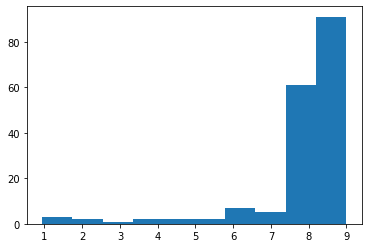

In [0]:
dfA = loadset('set_a.csv')

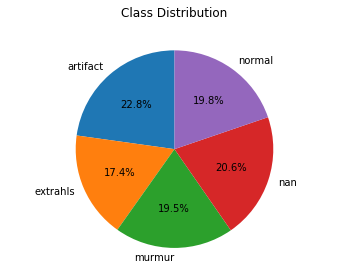

In [0]:
dfA.label = dfA.label.astype(str)
classes = list(np.unique(dfA.label))
class_dist = dfA.groupby(['label'])['length'].mean()
distplt(class_dist)

In [0]:
dfA.reset_index(inplace=True)

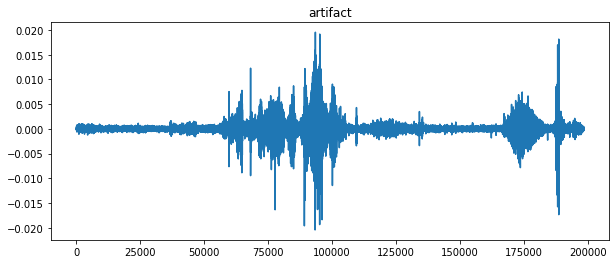

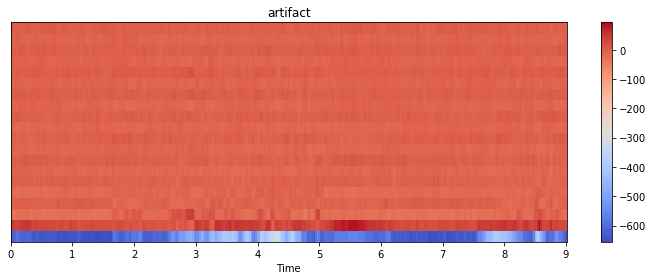

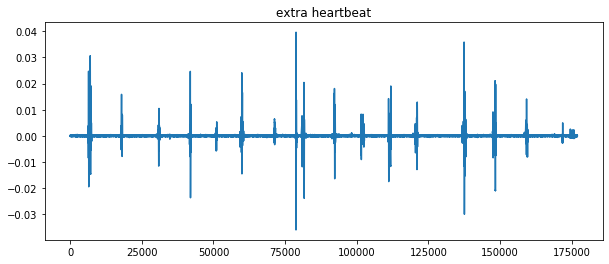

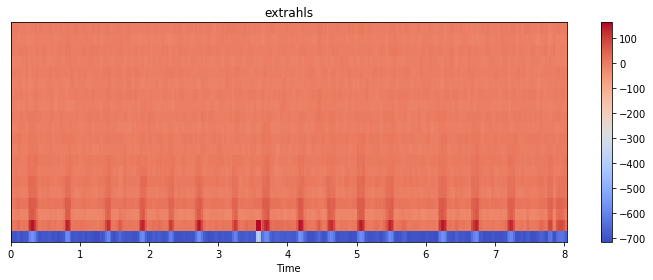

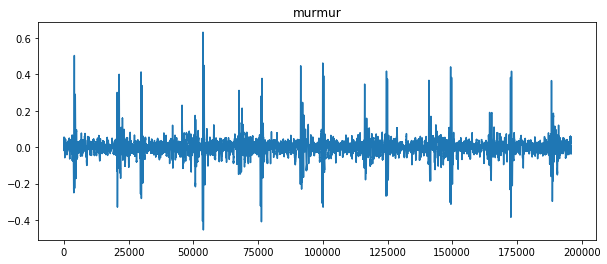

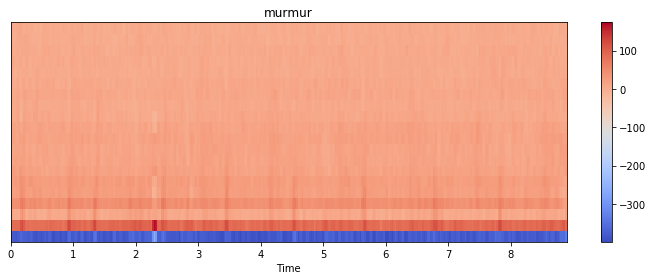

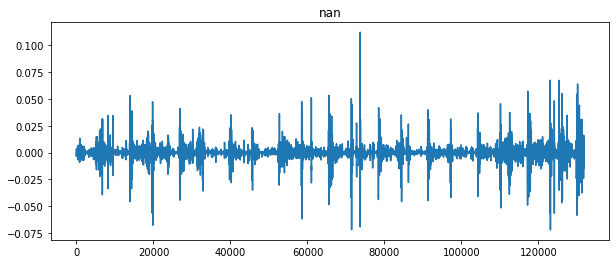

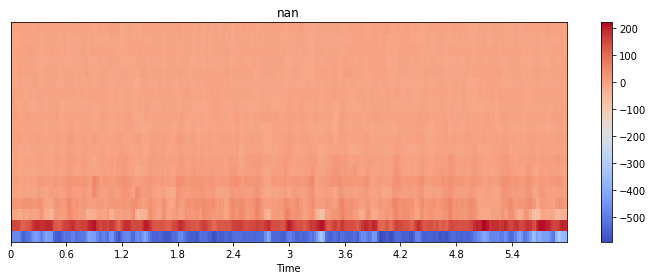

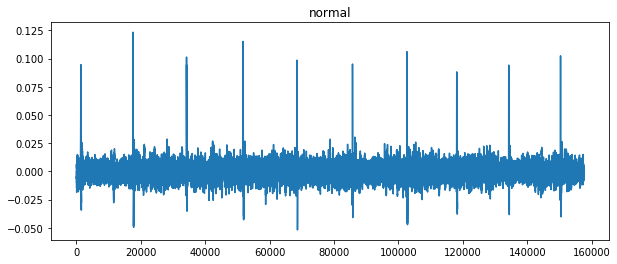

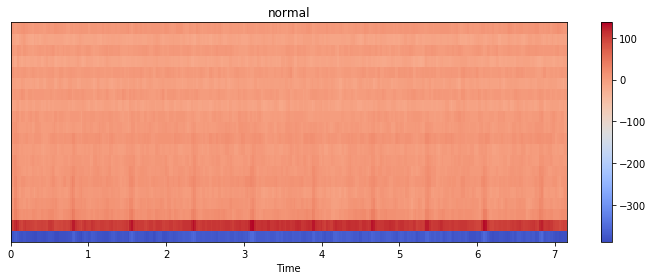

In [0]:
mfccs = {}
for c in classes:
    wav_file = dfA[dfA.label==c].fname.iloc[2]
    wav_file = re.sub(r'set_a\/__',r'set_a/Aunlabelledtest__',wav_file)
    signal, rate = librosa.load(wav_file, sr=22050)
    plt.figure(figsize=(10, 4))
    if c == 'extrahls':
        plt.title('extra heartbeat')
    else:
        plt.title(c)
    plt.plot(signal)
    mfcc = librosa.feature.mfcc(signal, rate)
    mfccs[c] = mfcc
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(c)
    plt.tight_layout()
    plt.show()

NOTE: Sound files do not load in loops so I just ran one as an example.

In [0]:
wav_file = dfA[dfA.label=='murmur'].fname.iloc[0]
print(wav_file)
ipd.Audio(wav_file)

##Model Creation

###Class and Functions

In [0]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13,nfft=2048,rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

In [0]:
def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index)
        file = np.random.choice(df[df.label==rand_class].index)
        file = re.sub(r'set_a\/__',r'set_a/Aunlabelledtest__',file)
        rate, wav = wavfile.read(file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = psfmfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        print(X_sample.shape)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode =='time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y = tf.keras.utils.to_categorical(y, num_classes = len(classes))

    return X, y

In [0]:
def get_conv_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
                            padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1),
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(classes), activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [0]:
def get_rnn_model():
    model = models.Sequential()
    model.add(layers.GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.TimeDistributed(layers.Dense(64, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(16, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(8, activation='relu')))
    model.add(layers.Flatten())
    model.add(layers.Dense(len(classes), activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

###Main

In [0]:
%%capture
df = loadset('set_a.csv')
df.label = df.label.astype(str)
df = df[~df.label.str.contains("nan")]
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

In [0]:
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [0]:
config = Config(mode='conv',nfeat=40)

In [0]:
X, y = build_rand_feat()

In [0]:
y_flat = np.argmax(y, axis=1)
if config.mode == 'conv':
    input_shape = (X.shape[1], X.shape[2], 1)
    print(input_shape)
    model = get_conv_model()
elif config.mode == 'time':
    input_shape = (X.shape[1], X.shape[2])
    model = get_rnn_model()

In [0]:
class_weight = compute_class_weight('balanced',
                                     np.unique(y_flat),
                                     y_flat)

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./', save_best_only=True)

In [0]:
history = model.fit(X, y, epochs=50, batch_size=32,
          callbacks=[checkpoint],
          shuffle=True,
          validation_split=0.2,
          class_weight=class_weight)

In [0]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate()